# Blood suger prediction using NHITS

In [1]:
%%capture
! pip install statsforecast s3fs datasetsforecast

In [2]:
%%capture
!pip install neuralforecast
#! pip install git+https://github.com/Nixtla/neuralforecast.git@main

In [3]:
import pandas as pd
import numpy as np
import os
import random

from statsforecast import StatsForecast
import matplotlib.pyplot as plt

In [4]:
from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss

from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

## Read the data

The input to `NeuralForecast` is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds` and `y`:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp or int) column should be either an integer indexing time or a datestampe ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.
We will rename the


In [5]:
!wget -P Data https://raw.githubusercontent.com/ChristopherKunze-Git/AdvancedTimeSeriesCourse-Engineering-Data/refs/heads/main/Data/train_multi_no_gaps.csv
!wget -P Data https://github.com/ChristopherKunze-Git/AdvancedTimeSeriesCourse-Engineering-Data/raw/refs/heads/main/Data/test_multi_no_gaps.csv
!wget -P Data https://github.com/ChristopherKunze-Git/AdvancedTimeSeriesCourse-Engineering-Data/raw/refs/heads/main/Data/test_p27_no_gaps.csv
!wget -P Data https://github.com/ChristopherKunze-Git/AdvancedTimeSeriesCourse-Engineering-Data/raw/refs/heads/main/Data/train_p27_no_gaps.csv


--2025-02-28 12:33:41--  https://raw.githubusercontent.com/ChristopherKunze-Git/AdvancedTimeSeriesCourse-Engineering-Data/refs/heads/main/Data/train_multi_no_gaps.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19414820 (19M) [text/plain]
Saving to: ‘Data/train_multi_no_gaps.csv.2’

train_multi_no_gaps 100%[===================>]  18.51M  34.3MB/s    in 0.5s    

2025-02-28 12:33:42 (34.3 MB/s) - ‘Data/train_multi_no_gaps.csv.2’ saved [19414820/19414820]

--2025-02-28 12:33:43--  https://github.com/ChristopherKunze-Git/AdvancedTimeSeriesCourse-Engineering-Data/raw/refs/heads/main/Data/test_multi_no_gaps.csv
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting 

In [5]:
# read in data
data_path=r'Data'
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

train_multi = pd.read_csv(os.path.join(data_path,'train_multi_no_gaps.csv'), date_format="%Y-%m-%dT%H:%M:%S")#, index_col="time")
test_multi = pd.read_csv(os.path.join(data_path,'test_multi_no_gaps.csv'), date_format="%Y-%m-%dT%H:%M:%S") #sep=';', date_format="%Y-%m-%dT%H:%M:%S", index_col="time")
train_p27 = pd.read_csv(os.path.join(data_path,'train_p27_no_gaps.csv'), date_format="%Y-%m-%dT%H:%M:%S") #sep=';', date_format="%Y-%m-%dT%H:%M:%S", index_col="time")
test_p27 = pd.read_csv(os.path.join(data_path,'test_p27_no_gaps.csv'), date_format="%Y-%m-%dT%H:%M:%S") #sep=';', date_format="%Y-%m-%dT%H:%M:%S", index_col="time")

test_p27 = test_p27.drop(columns={'old_time'})
train_p27 = train_p27.drop(columns={'old_time'})
test_multi = test_multi.drop(columns={'old_time'})
train_multi = train_multi.drop(columns={'old_time'})
#test_p27=test_p27.rename(columns={'old_time': 'time'})
#train_p27=train_p27.rename(columns={'old_time': 'time'})

train_multi['time'] = pd.to_datetime(train_multi['time'])
test_multi['time'] = pd.to_datetime(test_multi['time'])
train_p27['time'] = pd.to_datetime(train_p27['time'])
test_p27['time'] = pd.to_datetime(test_p27['time'])


In [6]:
train_multi.head(1)

time subj     glucose  burned_calories  heart_rate  \
0 2018-06-13 18:45:00  P01  329.333333            7.728   83.740157   

   basal_insulin  bolus_insulin  time_of_day  hour_sin  hour_cos  \
0       0.091667            0.0        18.75 -0.980785   0.19509   

   heart_rate_imp  glucose_imp  
0       83.740157   329.333333

In [7]:
# Rename the columns to fit the desired format
train_multi_renamed = train_multi.rename(columns={
    'time': 'ds',         # Rename 'time' to 'ds' (timestamp column)
    'glucose_imp': 'y',       # Rename 'glucose' to 'y' (target variable)
    'subj': 'unique_id'   # Rename 'subj' to 'unique_id' (unique identifier)
})

test_multi_renamed = test_multi.rename(columns={
    'time': 'ds',         # Rename 'time' to 'ds' (timestamp column)
    'glucose_imp': 'y',       # Rename 'glucose' to 'y' (target variable)
    'subj': 'unique_id'   # Rename 'subj' to 'unique_id' (unique identifier)
})

print(test_multi_renamed[['unique_id','ds', 'y' ]])

# univariat data:
train_multi_glucose=train_multi_renamed[['unique_id','ds', 'y' ]]
test_multi_glucose=test_multi_renamed[['unique_id','ds', 'y' ]]

      unique_id                  ds           y
0           P06 2018-07-09 15:45:00  109.000000
1           P06 2018-07-09 15:50:00  107.666667
2           P06 2018-07-09 15:55:00  106.333333
3           P06 2018-07-09 16:00:00  105.000000
4           P06 2018-07-09 16:05:00  122.333333
...         ...                 ...         ...
20011       P21 2019-07-11 15:15:00  148.000000
20012       P21 2019-07-11 15:20:00  148.666667
20013       P21 2019-07-11 15:25:00  149.333333
20014       P21 2019-07-11 15:30:00  150.000000
20015       P21 2019-07-11 15:35:00  156.000000

[20016 rows x 3 columns]


In [8]:
# Rename the columns to fit format
train_p27_renamed = train_p27.rename(columns={
    'time': 'ds',         # Rename 'time' to 'ds' (timestamp column)
    'glucose_imp': 'y',       # Rename 'glucose' to 'y' (target variable)
    'subj': 'unique_id'   # Rename 'subj' to 'unique_id' (unique identifier)
})
print(train_p27_renamed[['unique_id','ds', 'y' ]])

test_p27_renamed = test_p27.rename(columns={
    'time': 'ds',         # Rename 'time' to 'ds' (timestamp column)
    'glucose_imp': 'y',       # Rename 'glucose' to 'y' (target variable)
    'subj': 'unique_id'   # Rename 'subj' to 'unique_id' (unique identifier)
})
print(test_p27_renamed[['unique_id','ds', 'y' ]])

# univariat data
train_p27_glucose=train_p27_renamed[['unique_id','ds', 'y' ]]
test_p27_glucose=test_p27_renamed[['unique_id','ds', 'y' ]]

       unique_id                  ds           y
0            P27 2020-06-26 22:15:00  112.000000
1            P27 2020-06-26 22:20:00  105.000000
2            P27 2020-06-26 22:25:00   98.000000
3            P27 2020-06-26 22:30:00   91.000000
4            P27 2020-06-26 22:35:00   91.000000
...          ...                 ...         ...
120511       P27 2021-08-19 08:50:00  139.333333
120512       P27 2021-08-19 08:55:00  140.666667
120513       P27 2021-08-19 09:00:00  142.000000
120514       P27 2021-08-19 09:05:00  144.333333
120515       P27 2021-08-19 09:10:00  146.666667

[120516 rows x 3 columns]
      unique_id                  ds           y
0           P27 2021-08-19 09:15:00  149.000000
1           P27 2021-08-19 09:20:00  144.333333
2           P27 2021-08-19 09:25:00  139.666667
3           P27 2021-08-19 09:30:00  135.000000
4           P27 2021-08-19 09:35:00  135.666667
...         ...                 ...         ...
30124       P27 2021-12-01 23:35:00  177.000000
3

In [9]:
# drop redundant columns
train_p27_renamed = train_p27_renamed.drop(columns=['heart_rate', 'glucose'])
test_p27_renamed = test_p27_renamed.drop(columns=['heart_rate', 'glucose'])
train_multi_renamed = train_multi_renamed.drop(columns=['heart_rate', 'glucose'])
test_multi_renamed = test_multi_renamed.drop(columns=['heart_rate', 'glucose'])

In [10]:
train_p27_renamed.columns

Index(['ds', 'unique_id', 'burned_calories', 'basal_insulin', 'bolus_insulin',
       'hour_of_day', 'hour_sin', 'hour_cos', 'heart_rate_imp', 'y'],
      dtype='object')

In [11]:
# create full training set univariat
train_all_glucose= pd.concat([train_p27_glucose, train_multi_glucose], ignore_index=True)
train_all_glucose.head()

train_all_renamed= pd.concat([train_p27_renamed, train_multi_renamed], ignore_index=True)
train_all_renamed.head()

ds unique_id  burned_calories  basal_insulin  \
0 2020-06-26 22:15:00       P27        22.655359          0.066   
1 2020-06-26 22:20:00       P27        21.161600          0.066   
2 2020-06-26 22:25:00       P27        25.642880          0.066   
3 2020-06-26 22:30:00       P27        12.572480          0.066   
4 2020-06-26 22:35:00       P27         6.721920          0.066   

   bolus_insulin  hour_of_day  hour_sin  hour_cos  heart_rate_imp      y  \
0            0.0         22.0      -0.5  0.866025       81.000000  112.0   
1            0.0         22.0      -0.5  0.866025       84.625000  105.0   
2            0.0         22.0      -0.5  0.866025       89.222222   98.0   
3            0.0         22.0      -0.5  0.866025       80.027778   91.0   
4            0.0         22.0      -0.5  0.866025       75.108108   91.0   

   time_of_day  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

## Explore Data with the plot method of StatsForecast

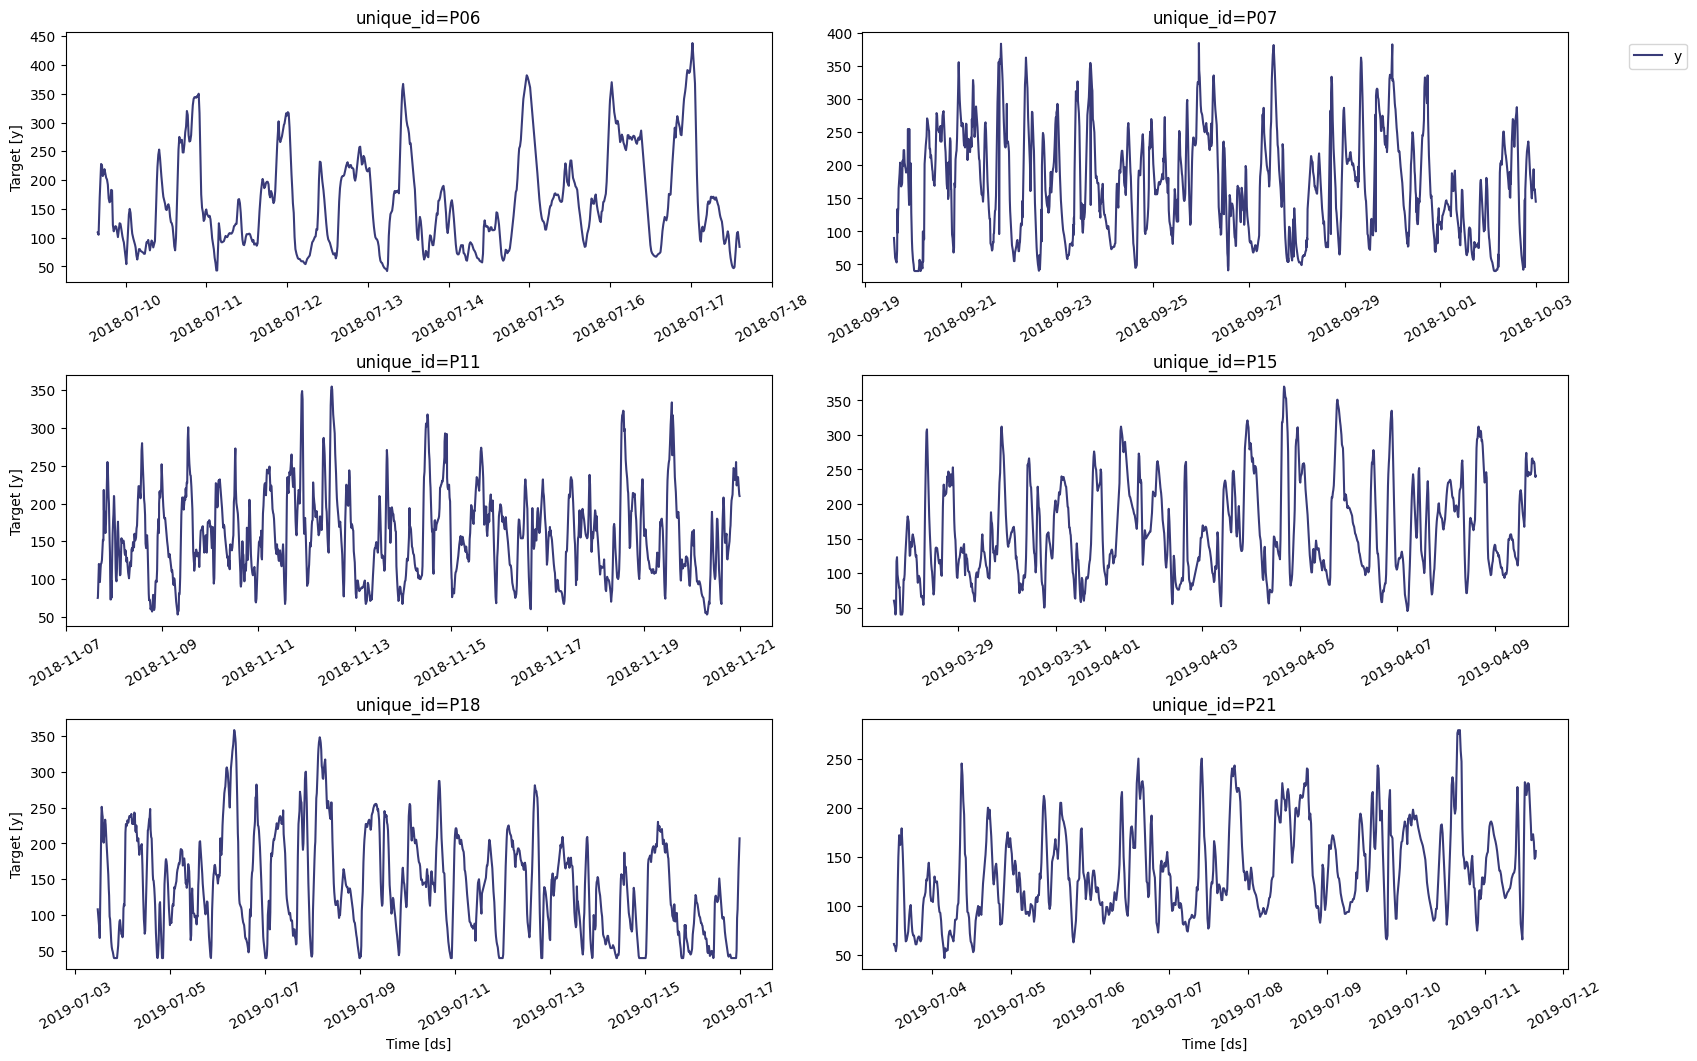

In [13]:
# dataset train_multi
StatsForecast.plot(test_multi_renamed, engine='matplotlib')

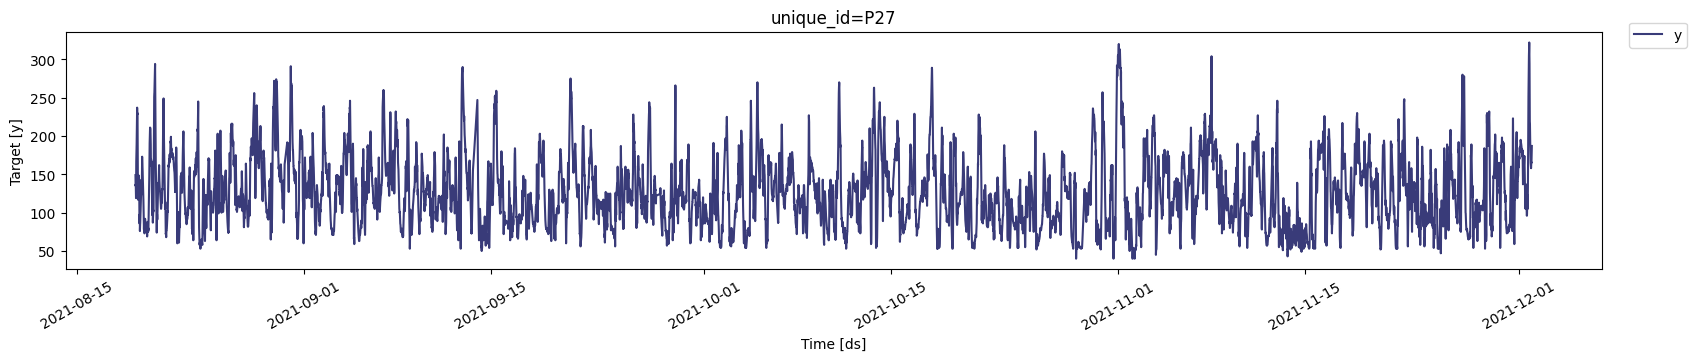

In [14]:
# dataset train_p27 - single object with long data
StatsForecast.plot(test_p27_renamed, engine='matplotlib')

## Train models 

In [12]:
horizon = 12 # 1h.

# Use your own config or AutoNHITS.default_config
config_nhits = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1000]),                                         # Number of SGD steps
       "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([128,256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "scaler_type": tune.choice([None, 'standard', 'robust']),                 # Scaler type - tune.choice(['None', 'MinMax', 'Standard'])
       "val_check_steps": tune.choice([100]),                                    # Compute validation every 100 epochs
       "random_seed": tune.randint(1, 10),
    }

To instantiate an `Auto` model you need to define:

* `h`: forecasting horizon.
* `loss`: training and validation loss from `neuralforecast.losses.pytorch`.
* `config`: hyperparameter search space. If `None`, the `Auto` class will use a pre-defined suggested hyperparameter space.
* `search_alg`: search algorithm (from `tune.search`), default is random search. Refer to https://docs.ray.io/en/latest/tune/api_docs/suggestion.html for more information on the different search algorithm options.
* `num_samples`: number of configurations explored.


### train on subject 27 - univariat data

In [13]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=12, config=config_nhits, loss=MQLoss(), num_samples=5), # problems with runinng high number of num_samples
    ],
    freq='5min'
)

train_data = train_p27_glucose

In [18]:
%%capture
nf.fit(df=train_data)

2025-02-28 12:34:02,016	INFO worker.py:1841 -- Started a local Ray instance.
2025-02-28 12:34:05,126	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2025-02-28 12:59:52,462	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2025-02-28_12-33-58' in 0.0106s.
INFO:lightning_fabric.utilities.seed:Seed set to 3
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | eval 
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  |

In [19]:
best_model = nf.models[0]
print(best_model.hparams)

"alias":          None
"backend":        ray
"callbacks":      None
"cls_model":      <class 'neuralforecast.models.nhits.NHITS'>
"config":         {'learning_rate': <ray.tune.search.sample.Categorical object at 0x7b45f7578c90>, 'max_steps': <ray.tune.search.sample.Categorical object at 0x7b45f7f69710>, 'input_size': <ray.tune.search.sample.Categorical object at 0x7b45f7f69b50>, 'batch_size': <ray.tune.search.sample.Categorical object at 0x7b45f7f6bed0>, 'windows_batch_size': <ray.tune.search.sample.Categorical object at 0x7b45f7f6c550>, 'n_pool_kernel_size': <ray.tune.search.sample.Categorical object at 0x7b45f7f6c690>, 'n_freq_downsample': <ray.tune.search.sample.Categorical object at 0x7b45f7f6c850>, 'activation': <ray.tune.search.sample.Categorical object at 0x7b45f7f6ca50>, 'n_blocks': <ray.tune.search.sample.Categorical object at 0x7b45f7f6cb90>, 'mlp_units': <ray.tune.search.sample.Categorical object at 0x7b45f7f6cd10>, 'interpolation_mode': <ray.tune.search.sample.Categorical o

In [20]:
# Get tuning results
tuning_results = nf.models[0].results.get_dataframe()

# Pretty print the top 5 results
print("\n🔹 Top 5 Tuning Results:")
print(tuning_results.to_string(index=False))


🔹 Top 5 Tuning Results:
    loss  train_loss  timestamp checkpoint_dir_name  done  training_iteration    trial_id                date  time_this_iter_s  time_total_s   pid     hostname     node_ip  time_since_restore  iterations_since_restore  config/learning_rate  config/max_steps  config/input_size  config/batch_size  config/windows_batch_size config/n_pool_kernel_size config/n_freq_downsample config/activation config/n_blocks                     config/mlp_units config/interpolation_mode config/scaler_type  config/val_check_steps  config/random_seed  config/h config/loss config/valid_loss      logdir
3.463860    0.337605 1740746329                None False                  10 3e1ce_00000 2025-02-28_12-38-49         28.668135    272.777875 32537 d025fee0ecf1 172.28.0.12          272.777875                        10                 0.001              1000                 60                  7                        128                [16, 8, 1]                [1, 1, 1]              

In [21]:
fcst_df = nf.predict()
fcst_df.columns = fcst_df.columns.str.replace('-median', '')
fcst_df.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id                  ds   AutoNHITS  AutoNHITS-lo-90  AutoNHITS-lo-80  \
0       P27 2021-08-19 09:15:00  147.431473       143.967560       145.825043   
1       P27 2021-08-19 09:20:00  147.151550       141.293961       144.139908   
2       P27 2021-08-19 09:25:00  147.807266       138.781982       142.368271   
3       P27 2021-08-19 09:30:00  148.723938       135.443314       139.516983   
4       P27 2021-08-19 09:35:00  148.812149       132.182098       136.233032   

   AutoNHITS-hi-80  AutoNHITS-hi-90  
0       149.683121       150.514374  
1       152.139786       153.875259  
2       154.922775       157.973618  
3       158.000305       161.031387  
4       160.621643       165.138397

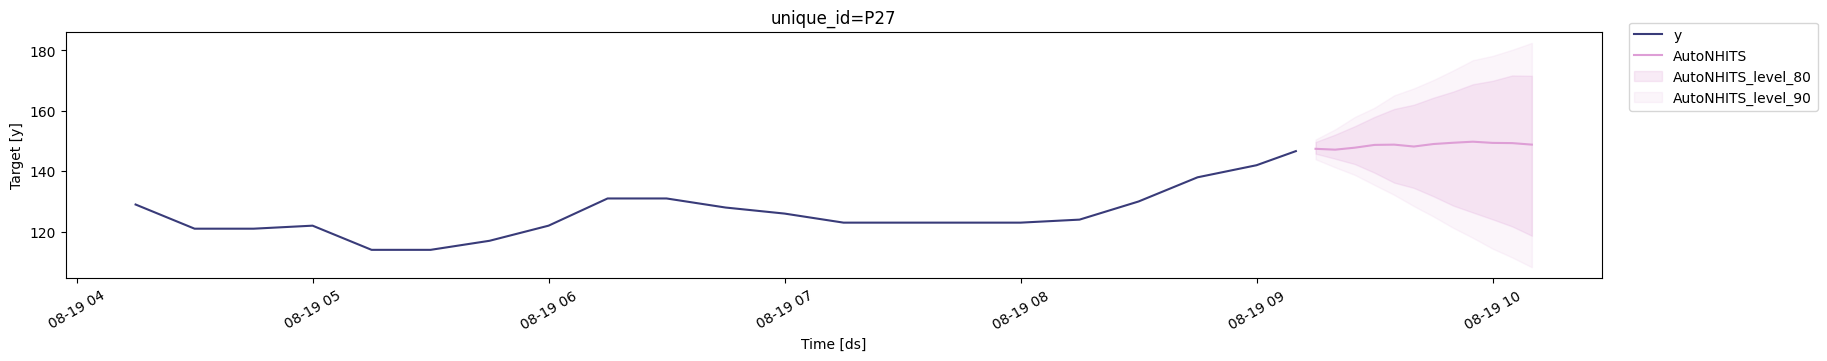

In [ ]:
StatsForecast.plot(train_data, fcst_df, engine='matplotlib', max_insample_length=12 * 5, level=[80, 90])

#### model evaluation

In [ ]:
cv_p27 = nf.cross_validation(test_p27_glucose,
                                    n_windows=len(test_p27_glucose) - 12 - 6*12,
                                    step_size=1)

In [26]:
# filters to data for 1h prediction
cv_p27_filtered = cv_p27[cv_p27['ds'] == cv_p27['cutoff'] + pd.Timedelta(minutes=60)]

In [27]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

##def mean_absolute_percentage_error(y_true, y_pred):
#    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mae = mean_absolute_error(cv_p27_filtered['y'], cv_p27_filtered['AutoNHITS-median'])
print(f"Mean Absolute Error (MAE): {mae}")

mape = mean_absolute_percentage_error(cv_p27_filtered['y'], cv_p27_filtered['AutoNHITS-median'])*100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 21.605557014424246
Mean Absolute Percentage Error (MAPE): 18.12%


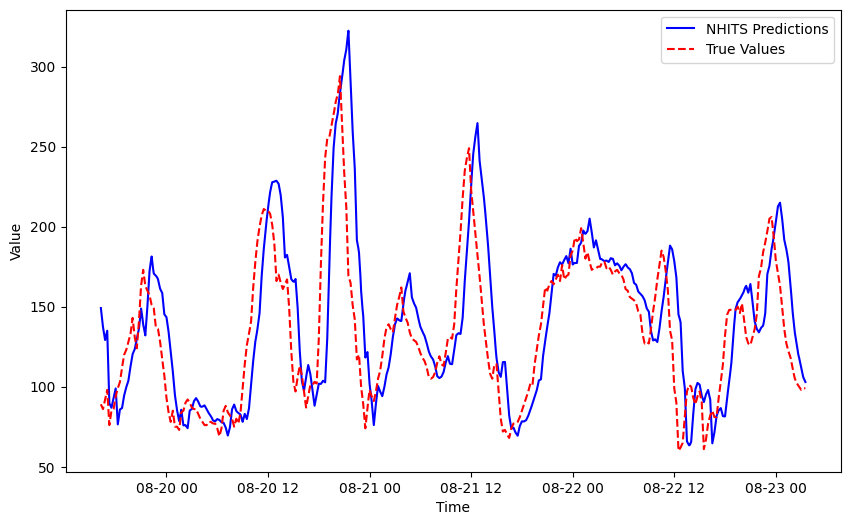

In [28]:
plot_data = cv_p27_filtered[:1000]

plt.figure(figsize=(10, 6))
plt.plot(plot_data['ds'], plot_data['AutoNHITS-median'], label='NHITS Predictions', color='blue')
plt.plot(plot_data['ds'], plot_data['y'], label='True Values', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### train on subject 27 - multivariate

In [ ]:
nf = NeuralForecast(
    models=[
        AutoNHITS(h=12, config=config_nhits, loss=MQLoss(), num_samples=15),
    ],
    freq='5min'
)

In [ ]:
%%capture
nf.fit(df=train_p27_renamed)

2025-02-28 02:05:38,912	INFO worker.py:1841 -- Started a local Ray instance.
2025-02-28 02:05:40,779	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2025-02-28 04:08:11,869	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/_train_tune_2025-02-28_02-05-34' in 0.0224s.
INFO:lightning_fabric.utilities.seed:Seed set to 6
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | eval 
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  |

In [ ]:
best_model = nf.models[0]
print(best_model.hparams)

"alias":          None
"backend":        ray
"callbacks":      None
"cls_model":      <class 'neuralforecast.models.nhits.NHITS'>
"config":         {'input_size': <ray.tune.search.sample.Categorical object at 0x7ca971f19e50>, 'start_padding_enabled': True, 'n_blocks': <ray.tune.search.sample.Categorical object at 0x7ca971efbe10>, 'mlp_units': [[64, 64], [64, 64], [64, 64], [64, 64], [64, 64]], 'n_pool_kernel_size': <ray.tune.search.sample.Categorical object at 0x7ca9741ec090>, 'n_freq_downsample': <ray.tune.search.sample.Categorical object at 0x7ca9741ec3d0>, 'learning_rate': <ray.tune.search.sample.Float object at 0x7ca9741ec610>, 'scaler_type': <ray.tune.search.sample.Categorical object at 0x7ca9741ec790>, 'max_steps': <ray.tune.search.sample.Categorical object at 0x7ca9741ec8d0>, 'batch_size': <ray.tune.search.sample.Categorical object at 0x7ca9741eca10>, 'windows_batch_size': <ray.tune.search.sample.Categorical object at 0x7ca9741ecb50>, 'random_seed': <ray.tune.search.sample.Integ

In [ ]:
# Get tuning results
tuning_results = nf.models[0].results.get_dataframe()

# Pretty print the top 5 results
print("\n🔹 Top 5 Tuning Results:")
print(tuning_results.to_string(index=False))


🔹 Top 5 Tuning Results:
    loss  train_loss  timestamp checkpoint_dir_name  done  training_iteration    trial_id                date  time_this_iter_s  time_total_s   pid     hostname     node_ip  time_since_restore  iterations_since_restore  config/input_size  config/start_padding_enabled config/n_blocks                                   config/mlp_units config/n_pool_kernel_size config/n_freq_downsample  config/learning_rate config/scaler_type  config/max_steps  config/batch_size  config/windows_batch_size  config/random_seed  config/h config/loss config/valid_loss      logdir
3.433228    0.521128 1740708780                None False                  10 7b245_00000 2025-02-28_02-13-00         42.260418    427.019627  1722 04d06a5e3cef 172.28.0.12          427.019627                        10                 24                          True [2, 2, 2, 2, 2] [[64, 64], [64, 64], [64, 64], [64, 64], [64, 64]]           [8, 4, 2, 1, 1]          [1, 1, 1, 1, 1]              0.000194     

In [ ]:
fcst_df = nf.predict()
fcst_df.columns = fcst_df.columns.str.replace('-median', '')
fcst_df.head()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id                  ds   AutoNHITS  AutoNHITS-lo-90  AutoNHITS-lo-80  \
0       P27 2021-08-19 09:15:00  148.414413       145.626175       146.597916   
1       P27 2021-08-19 09:20:00  149.166473       145.036728       145.895203   
2       P27 2021-08-19 09:25:00  149.649612       140.752274       145.351654   
3       P27 2021-08-19 09:30:00  151.022659       139.580399       141.764191   
4       P27 2021-08-19 09:35:00  151.058929       136.319901       141.175507   

   AutoNHITS-hi-80  AutoNHITS-hi-90  
0       149.273743       149.853683  
1       152.805038       155.029861  
2       155.306885       159.411301  
3       157.816772       161.418823  
4       160.732986       164.878159

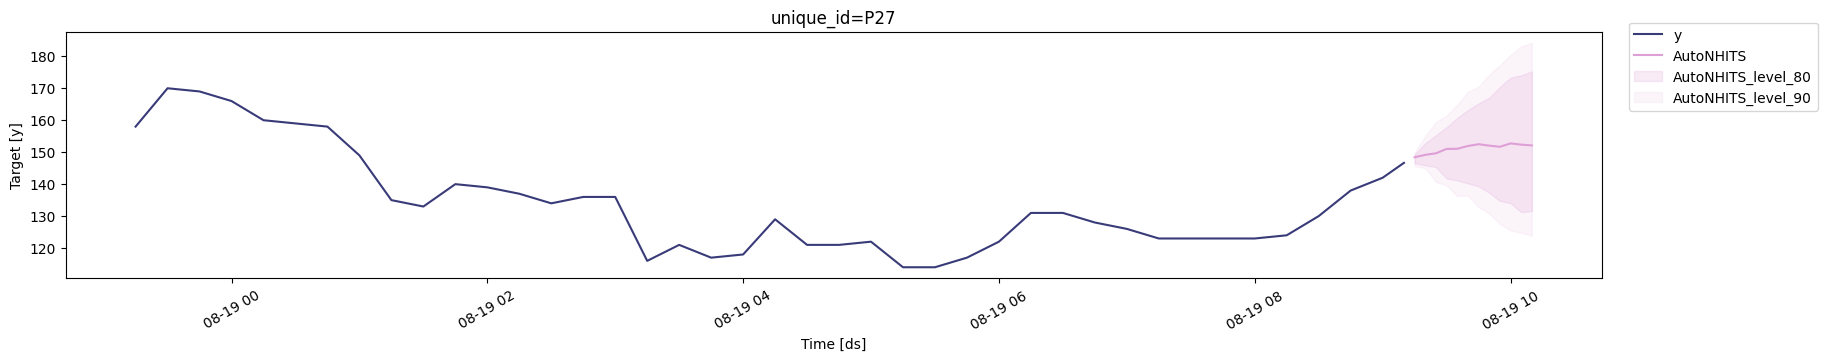

In [ ]:
StatsForecast.plot(train_p27_renamed, fcst_df, engine='matplotlib', max_insample_length=12 * 10, level=[80, 90])

#### model evaluation

In [ ]:
cv_p27 = nf.cross_validation(test_p27_glucose,
                                    n_windows=len(test_p27_glucose) - 12 - 6*12,
                                    step_size=1)

In [ ]:
# filters to data for 1h prediction
cv_p27_filtered = cv_p27[cv_p27['ds'] == cv_p27['cutoff'] + pd.Timedelta(minutes=60)]

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

##def mean_absolute_percentage_error(y_true, y_pred):
#    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mae = mean_absolute_error(cv_p27_filtered['y'], cv_p27_filtered['AutoNHITS-median'])
print(f"Mean Absolute Error (MAE): {mae}")

mape = mean_absolute_percentage_error(cv_p27_filtered['y'], cv_p27_filtered['AutoNHITS-median'])*100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 31.457635102531075
Mean Absolute Percentage Error (MAPE): 27.63%


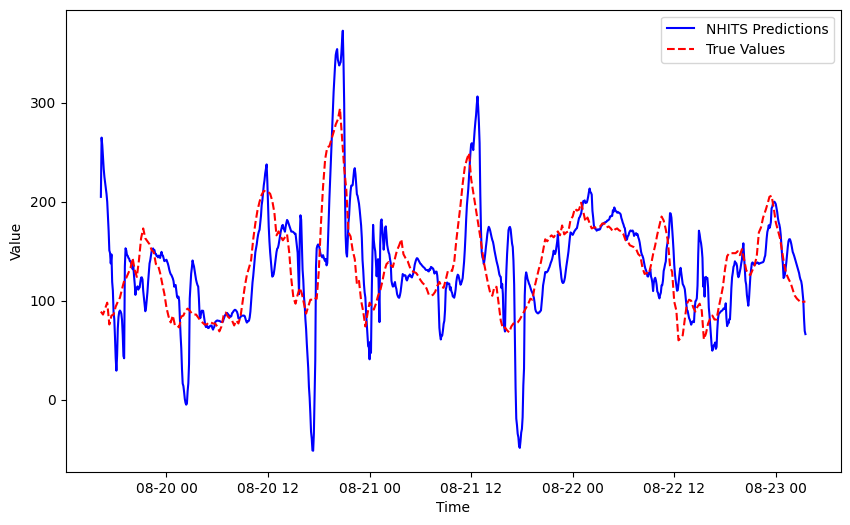

In [ ]:
plot_data = cv_p27_filtered[:1000]

plt.figure(figsize=(10, 6))
plt.plot(plot_data['ds'], plot_data['AutoNHITS-median'], label='NHITS Predictions', color='blue')
plt.plot(plot_data['ds'], plot_data['y'], label='True Values', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### train subject 27 - num_samples=50

In [15]:
config_nhits = {
    "input_size": tune.choice([12, 12*2, 12*4]),              # Length of input window (12 is 1h)
    "start_padding_enabled": True,
    "n_blocks": tune.choice([5*[1], 5*[2], 5*[4]]),#5*[1],                                              # Length of input window
    "mlp_units": 5 * [[64, 64]],                                  # Length of input window
    "n_pool_kernel_size": tune.choice([5*[1], 5*[2], 5*[4],
                                      [8, 4, 2, 1, 1]]),            # MaxPooling Kernel size
    "n_freq_downsample": tune.choice([[8, 4, 2, 1, 1],
                                      [1, 1, 1, 1, 1]]),            # Interpolation expressivity ratios
    "learning_rate": tune.loguniform(1e-4, 1e-2),                   # Initial Learning rate
    "scaler_type": tune.choice([None, 'standard', 'robust']),                             # Scaler type - tune.choice(['None', 'MinMax', 'Standard'])
    "max_steps": tune.choice([1000]),                               # Max number of training iterations
    "batch_size": tune.choice([1, 4, 10]),                          # Number of series in batch
    "windows_batch_size": tune.choice([32, 64, 128, 256]),             # Number of windows in batch
    "random_seed": tune.randint(1, 20),                             # Random seed
}


In [ ]:
nf_p27_MQ = NeuralForecast(
    models=[
        AutoNHITS(h=12, config=config_nhits, loss=MQLoss(), num_samples=50),
        #AutoLSTM(h=12, config=config_lstm, loss=MQLoss(), num_samples=2),
    ],
    freq='5min'
)
nf_p27_MQ.fit(train_p27_glucose)

2025-02-26 15:00:06,307	INFO worker.py:1841 -- Started a local Ray instance.
2025-02-26 15:00:08,490	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.


+--------------------------------------------------------------------+
| Configuration for experiment     _train_tune_2025-02-26_15-00-01   |
+--------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator             |
| Scheduler                        FIFOScheduler                     |
| Number of trials                 50                                |
+--------------------------------------------------------------------+

View detailed results here: /root/ray_results/_train_tune_2025-02-26_15-00-01
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts`


(pid=2627) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=2627) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=2627) 
(pid=2627) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=2627) This will raise in a future version.
(pid=2627) 
(pid=2627)   warnings.warn(msg, FutureWarning)
(_train_tune pid=2627) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=2627) Seed set to 6
2025-02-26 15:00:21,294	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00000
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
   


Trial _train_tune_3cc19_00000 errored after 0 iterations at 2025-02-26 15:00:21. Total running time: 11s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00000_0_batch_size=10,input_size=24,learning_rate=0.0002,max_steps=1000,n_blocks=2_2_2_2_2,n_freq_downsample=1_1_2025-02-26_15-00-09/error.txt


(pid=2756) 
(pid=2756) 
(pid=2756) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=2756) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=2756) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=2756) This will raise in a future version.
(pid=2756)   warnings.warn(msg, FutureWarning)
(_train_tune pid=2756) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=2756) Seed set to 1
2025-02-26 15:00:34,190	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00001
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
   


Trial _train_tune_3cc19_00001 errored after 0 iterations at 2025-02-26 15:00:34. Total running time: 24s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00001_1_batch_size=4,input_size=72,learning_rate=0.0007,max_steps=1000,n_blocks=2_2_2_2_2,n_freq_downsample=1_1__2025-02-26_15-00-10/error.txt


(pid=2875) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=2875) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=2875) 
(pid=2875) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=2875) This will raise in a future version.
(pid=2875) 
(pid=2875)   warnings.warn(msg, FutureWarning)
(_train_tune pid=2875) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=2875) Seed set to 6
(_train_tune pid=2875) GPU available: False, used: False
(_train_tune pid=2875) TPU available: False, using: 0 TPU cores
(_train_tune pid=2875) HPU available: False, using: 0 HPUs
(_train_tune pid=2875) 2025-02-26 15:00:48.678510: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unabl

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s, v_num=0, train_loss_step=3.770, train_loss_epoch=3.800]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s, v_num=0, train_loss_step=3.200, train_loss_epoch=3.270, valid_loss=2.460]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s, v_num=0, train_loss_step=3.500, train_loss_epoch=3.350, valid_loss=2.880]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  4.25it/s, v_num=0, train_loss_step=3.140, train_loss_epoch=3.580, valid_loss=2.130]
(_train_tune pid=2875) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=2875) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=2875) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.23it/s, v_num=0, train_loss_step=3.110, train_loss_epoch=2.870, valid_loss=2.270]
Validation: |          | 0/? [00:00<?, ?it/s]

(_train_tune pid=2875) `Trainer.fit` stopped: `max_steps=1000` reached.
(pid=4458) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=4458) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=4458) 
(pid=4458) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=4458) This will raise in a future version.
(pid=4458) 
(pid=4458)   warnings.warn(msg, FutureWarning)
(_train_tune pid=4458) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=4458) Seed set to 5
2025-02-26 15:06:56,334	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00003
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_m


Trial _train_tune_3cc19_00003 errored after 0 iterations at 2025-02-26 15:06:56. Total running time: 6min 46s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00003_3_batch_size=1,input_size=12,learning_rate=0.0006,max_steps=1000,n_blocks=2_2_2_2_2,n_freq_downsample=8_4__2025-02-26_15-00-10/error.txt


(pid=4584) 
(pid=4584) 
(pid=4584) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=4584) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=4584) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=4584) This will raise in a future version.
(pid=4584)   warnings.warn(msg, FutureWarning)
(_train_tune pid=4584) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=4584) Seed set to 19
(_train_tune pid=4584) GPU available: False, used: False
(_train_tune pid=4584) TPU available: False, using: 0 TPU cores
(_train_tune pid=4584) HPU available: False, using: 0 HPUs
(_train_tune pid=4584) 2025-02-26 15:07:07.628258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unab

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  9.69it/s, v_num=0, train_loss_step=3.310, train_loss_epoch=3.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 10.01it/s, v_num=0, train_loss_step=2.860, train_loss_epoch=3.030, valid_loss=2.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.55it/s]
(_train_tune pid=4584) 
                                                                       
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s, v_num=0, train_loss_step=2.890, train_loss_epoch=3.200, valid_loss=2.860]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  9.87it/s, v_num=0, train_loss_step=2.750, train_loss_epoch=2.790, valid_loss=3.140]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  7.50it/s, v_num=0, train_loss_step=2.910, train_loss_epoch=2.930, valid_loss=2.040]
Validation: 

(_train_tune pid=4584) `Trainer.fit` stopped: `max_steps=1000` reached.
(pid=5278) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=5278) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=5278) 
(pid=5278) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=5278) This will raise in a future version.
(pid=5278) 
(pid=5278)   warnings.warn(msg, FutureWarning)
(_train_tune pid=5278) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=5278) Seed set to 19
2025-02-26 15:09:40,622	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00005
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_


Trial _train_tune_3cc19_00005 errored after 0 iterations at 2025-02-26 15:09:40. Total running time: 9min 31s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00005_5_batch_size=1,input_size=12,learning_rate=0.0004,max_steps=1000,n_blocks=4_4_4_4_4,n_freq_downsample=1_1__2025-02-26_15-00-10/error.txt


(pid=5403) 
(pid=5403) 
(pid=5403) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=5403) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=5403) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=5403) This will raise in a future version.
(pid=5403)   warnings.warn(msg, FutureWarning)
(_train_tune pid=5403) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=5403) Seed set to 12
(_train_tune pid=5403) GPU available: False, used: False
(_train_tune pid=5403) TPU available: False, using: 0 TPU cores
(_train_tune pid=5403) HPU available: False, using: 0 HPUs
(_train_tune pid=5403) 2025-02-26 15:09:52.329580: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unab

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s, v_num=0, train_loss_step=3.510, train_loss_epoch=3.620]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  7.27it/s, v_num=0, train_loss_step=3.070, train_loss_epoch=2.860, valid_loss=2.630]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  7.82it/s, v_num=0, train_loss_step=2.850, train_loss_epoch=2.970, valid_loss=2.780]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s, v_num=0, train_loss_step=2.400, train_loss_epoch=3.050, valid_loss=1.930]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  8.46it/s, v_num=0, train_loss_step=2.870, train_loss_epoch=3.090, valid_loss=3.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s, v_num=0, train_loss_step=2.760, train_loss_epoch=2.940, valid_loss=2.150]
Val

(_train_tune pid=5403) `Trainer.fit` stopped: `max_steps=1000` reached.
(pid=6116) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=6116) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=6116) 
(pid=6116) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=6116) This will raise in a future version.
(pid=6116) 
(pid=6116)   warnings.warn(msg, FutureWarning)
(_train_tune pid=6116) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=6116) Seed set to 2
2025-02-26 15:12:29,910	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00007
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_m


Trial _train_tune_3cc19_00007 errored after 0 iterations at 2025-02-26 15:12:29. Total running time: 12min 20s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00007_7_batch_size=4,input_size=72,learning_rate=0.0011,max_steps=1000,n_blocks=4_4_4_4_4,n_freq_downsample=8_4__2025-02-26_15-00-10/error.txt


(pid=6241) 
(pid=6241) 
(pid=6241) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=6241) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=6241) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=6241) This will raise in a future version.
(pid=6241)   warnings.warn(msg, FutureWarning)
(_train_tune pid=6241) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=6241) Seed set to 16
2025-02-26 15:12:42,044	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00008
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  


Trial _train_tune_3cc19_00008 errored after 0 iterations at 2025-02-26 15:12:42. Total running time: 12min 32s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00008_8_batch_size=1,input_size=24,learning_rate=0.0015,max_steps=1000,n_blocks=2_2_2_2_2,n_freq_downsample=1_1__2025-02-26_15-00-10/error.txt


(pid=6362) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=6362) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=6362) 
(pid=6362) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=6362) This will raise in a future version.
(pid=6362) 
(pid=6362)   warnings.warn(msg, FutureWarning)
(_train_tune pid=6362) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=6362) Seed set to 16
(_train_tune pid=6362) GPU available: False, used: False
(_train_tune pid=6362) TPU available: False, using: 0 TPU cores
(_train_tune pid=6362) HPU available: False, using: 0 HPUs
(_train_tune pid=6362) 2025-02-26 15:12:54.763456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unab

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s, v_num=0, train_loss_step=3.210, train_loss_epoch=3.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6362) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 156.66it/s]
(_train_tune pid=6362) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s, v_num=0, train_loss_step=3.010, train_loss_epoch=3.090, valid_loss=2.890]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s, v_num=0, train_loss_step=3.420, train_loss_epoch=2.820, valid_loss=1.980]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  5.52it/s, v_num=0, train_loss_step=2.960, train_loss_epoch=2.780, valid_loss=1.960]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=6362) 
Epoch 499: 100%|██████████| 1/1 [00:00<00

(_train_tune pid=6362) `Trainer.fit` stopped: `max_steps=1000` reached.
(pid=7315) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=7315) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=7315) 
(pid=7315) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=7315) This will raise in a future version.
(pid=7315) 
(pid=7315)   warnings.warn(msg, FutureWarning)
(_train_tune pid=7315) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=7315) Seed set to 4
2025-02-26 15:16:29,561	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00010
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_m


Trial _train_tune_3cc19_00010 errored after 0 iterations at 2025-02-26 15:16:29. Total running time: 16min 19s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00010_10_batch_size=10,input_size=12,learning_rate=0.0002,max_steps=1000,n_blocks=4_4_4_4_4,n_freq_downsample=1__2025-02-26_15-00-10/error.txt


(pid=7432) 
(pid=7432) 
(pid=7432) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=7432) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=7432) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=7432) This will raise in a future version.
(pid=7432)   warnings.warn(msg, FutureWarning)
(_train_tune pid=7432) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=7432) Seed set to 9
2025-02-26 15:16:40,837	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00011
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
   


Trial _train_tune_3cc19_00011 errored after 0 iterations at 2025-02-26 15:16:40. Total running time: 16min 31s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00011_11_batch_size=10,input_size=24,learning_rate=0.0053,max_steps=1000,n_blocks=1_1_1_1_1,n_freq_downsample=1__2025-02-26_15-00-10/error.txt


(pid=7558) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=7558) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=7558) 
(pid=7558) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=7558) This will raise in a future version.
(pid=7558) 
(pid=7558)   warnings.warn(msg, FutureWarning)
(_train_tune pid=7558) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=7558) Seed set to 16
(_train_tune pid=7558) GPU available: False, used: False
(_train_tune pid=7558) TPU available: False, using: 0 TPU cores
(_train_tune pid=7558) HPU available: False, using: 0 HPUs
(_train_tune pid=7558) 2025-02-26 15:16:53.572478: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unab

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s, v_num=0, train_loss_step=3.310, train_loss_epoch=3.270]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s, v_num=0, train_loss_step=2.970, train_loss_epoch=3.070, valid_loss=2.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 291.74it/s]
(_train_tune pid=7558) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  5.91it/s, v_num=0, train_loss_step=3.290, train_loss_epoch=2.690, valid_loss=2.220]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s, v_num=0, train_loss_step=2.910, train_loss_epoch=2.810, valid_loss=2.820]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  3.40it/s, v_num=0, train_loss_step=2.990, train_loss_epoch=3.100, valid_loss=3.050]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00

(_train_tune pid=7558) `Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, v_num=0, train_loss_step=3.040, train_loss_epoch=2.850, valid_loss=2.040]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  4.51it/s, v_num=0, train_loss_step=3.040, train_loss_epoch=3.040, valid_loss=2.360]


(pid=8475) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=8475) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=8475) 
(pid=8475) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=8475) This will raise in a future version.
(pid=8475) 
(pid=8475)   warnings.warn(msg, FutureWarning)
(_train_tune pid=8475) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=8475) Seed set to 19
2025-02-26 15:20:20,135	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00013
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  


Trial _train_tune_3cc19_00013 errored after 0 iterations at 2025-02-26 15:20:20. Total running time: 20min 10s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00013_13_batch_size=10,input_size=72,learning_rate=0.0019,max_steps=1000,n_blocks=1_1_1_1_1,n_freq_downsample=8__2025-02-26_15-00-10/error.txt


(pid=8597) 
(pid=8597) 
(pid=8597) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=8597) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=8597) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=8597) This will raise in a future version.
(pid=8597)   warnings.warn(msg, FutureWarning)
(_train_tune pid=8597) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=8597) Seed set to 12
2025-02-26 15:20:32,456	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00014
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  


Trial _train_tune_3cc19_00014 errored after 0 iterations at 2025-02-26 15:20:32. Total running time: 20min 22s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00014_14_batch_size=4,input_size=72,learning_rate=0.0062,max_steps=1000,n_blocks=1_1_1_1_1,n_freq_downsample=8_4_2025-02-26_15-00-10/error.txt


(pid=8719) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=8719) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=8719) 
(pid=8719) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=8719) This will raise in a future version.
(pid=8719) 
(pid=8719)   warnings.warn(msg, FutureWarning)
(_train_tune pid=8719) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=8719) Seed set to 17
2025-02-26 15:20:44,573	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00015
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  


Trial _train_tune_3cc19_00015 errored after 0 iterations at 2025-02-26 15:20:44. Total running time: 20min 34s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00015_15_batch_size=10,input_size=72,learning_rate=0.0069,max_steps=1000,n_blocks=1_1_1_1_1,n_freq_downsample=1__2025-02-26_15-00-10/error.txt


(pid=8841) 
(pid=8841) 
(pid=8841) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=8841) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=8841) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=8841) This will raise in a future version.
(pid=8841)   warnings.warn(msg, FutureWarning)
(_train_tune pid=8841) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=8841) Seed set to 16
2025-02-26 15:20:57,211	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00016
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  


Trial _train_tune_3cc19_00016 errored after 0 iterations at 2025-02-26 15:20:57. Total running time: 20min 47s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00016_16_batch_size=1,input_size=12,learning_rate=0.0034,max_steps=1000,n_blocks=2_2_2_2_2,n_freq_downsample=8_4_2025-02-26_15-00-10/error.txt


(pid=8968) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=8968) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=8968) 
(pid=8968) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=8968) This will raise in a future version.
(pid=8968) 
(pid=8968)   warnings.warn(msg, FutureWarning)
(_train_tune pid=8968) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=8968) Seed set to 7
(_train_tune pid=8968) GPU available: False, used: False
(_train_tune pid=8968) TPU available: False, using: 0 TPU cores
(_train_tune pid=8968) HPU available: False, using: 0 HPUs
(_train_tune pid=8968) 2025-02-26 15:21:10.770136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unabl

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 32.60it/s]
                                                                           
Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s, v_num=0, train_loss_step=3.410, train_loss_epoch=3.520]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 210.44it/s]
(_train_tune pid=8968) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s, v_num=0, train_loss_step=3.580, train_loss_epoch=3.520, valid_loss=2.710]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  5.61it/s, v_num=0, train_loss_step=3.470, train_loss_epoch=3.310, valid_loss=2.670]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s, v_num=0, train_loss_step=3.610, train_loss_epoch=3.340, valid_loss=2.580]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s, v_num=

(_train_tune pid=8968) `Trainer.fit` stopped: `max_steps=1000` reached.
(pid=9671) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=9671) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=9671) 
(pid=9671) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=9671) This will raise in a future version.
(pid=9671) 
(pid=9671)   warnings.warn(msg, FutureWarning)
(_train_tune pid=9671) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=9671) Seed set to 5
2025-02-26 15:23:45,385	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00018
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_m


Trial _train_tune_3cc19_00018 errored after 0 iterations at 2025-02-26 15:23:45. Total running time: 23min 35s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00018_18_batch_size=1,input_size=12,learning_rate=0.0006,max_steps=1000,n_blocks=4_4_4_4_4,n_freq_downsample=8_4_2025-02-26_15-00-10/error.txt


(pid=9797) 
(pid=9797) 
(pid=9797) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=9797) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=9797) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=9797) This will raise in a future version.
(pid=9797)   warnings.warn(msg, FutureWarning)
(_train_tune pid=9797) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=9797) Seed set to 14
2025-02-26 15:23:57,436	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00019
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  


Trial _train_tune_3cc19_00019 errored after 0 iterations at 2025-02-26 15:23:57. Total running time: 23min 47s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00019_19_batch_size=4,input_size=48,learning_rate=0.0018,max_steps=1000,n_blocks=2_2_2_2_2,n_freq_downsample=8_4_2025-02-26_15-00-10/error.txt


(pid=9918) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=9918) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=9918) 
(pid=9918) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=9918) This will raise in a future version.
(pid=9918) 
(pid=9918)   warnings.warn(msg, FutureWarning)
(_train_tune pid=9918) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=9918) Seed set to 16
(_train_tune pid=9918) GPU available: False, used: False
(_train_tune pid=9918) TPU available: False, using: 0 TPU cores
(_train_tune pid=9918) HPU available: False, using: 0 HPUs
(_train_tune pid=9918) 2025-02-26 15:24:08.669565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unab

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  5.75it/s, v_num=0, train_loss_step=3.100, train_loss_epoch=3.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  3.53it/s, v_num=0, train_loss_step=3.260, train_loss_epoch=3.460, valid_loss=2.260]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  5.79it/s, v_num=0, train_loss_step=3.410, train_loss_epoch=3.010, valid_loss=3.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s, v_num=0, train_loss_step=2.950, train_loss_epoch=2.880, valid_loss=2.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.87it/s]
(_train_tune pid=9918) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  5.51it/s, v_num=0, train_loss_step=3.340, train_loss_epoch=3.040, valid_loss=2.130]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00

(_train_tune pid=9918) `Trainer.fit` stopped: `max_steps=1000` reached.
(pid=10872) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=10872) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=10872) 
(pid=10872) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=10872) This will raise in a future version.
(pid=10872) 
(pid=10872)   warnings.warn(msg, FutureWarning)
(_train_tune pid=10872) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=10872) Seed set to 5
2025-02-26 15:27:44,251	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00021
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_interna


Trial _train_tune_3cc19_00021 errored after 0 iterations at 2025-02-26 15:27:44. Total running time: 27min 34s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00021_21_batch_size=10,input_size=24,learning_rate=0.0002,max_steps=1000,n_blocks=2_2_2_2_2,n_freq_downsample=1__2025-02-26_15-00-10/error.txt


(pid=10994) 
(pid=10994) 
(pid=10994) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=10994) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=10994) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=10994) This will raise in a future version.
(pid=10994)   warnings.warn(msg, FutureWarning)
(_train_tune pid=10994) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=10994) Seed set to 14
2025-02-26 15:27:57,440	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00022
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(f


Trial _train_tune_3cc19_00022 errored after 0 iterations at 2025-02-26 15:27:57. Total running time: 27min 47s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00022_22_batch_size=10,input_size=12,learning_rate=0.0003,max_steps=1000,n_blocks=1_1_1_1_1,n_freq_downsample=8__2025-02-26_15-00-10/error.txt


(pid=11120) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=11120) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=11120) 
(pid=11120) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=11120) This will raise in a future version.
(pid=11120) 
(pid=11120)   warnings.warn(msg, FutureWarning)
(_train_tune pid=11120) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=11120) Seed set to 9
(_train_tune pid=11120) GPU available: False, used: False
(_train_tune pid=11120) TPU available: False, using: 0 TPU cores
(_train_tune pid=11120) HPU available: False, using: 0 HPUs
(_train_tune pid=11120) 2025-02-26 15:28:10.443089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s, v_num=0, train_loss_step=3.330, train_loss_epoch=3.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s, v_num=0, train_loss_step=3.350, train_loss_epoch=3.200, valid_loss=2.820]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  4.20it/s, v_num=0, train_loss_step=3.600, train_loss_epoch=3.380, valid_loss=2.600]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  4.41it/s, v_num=0, train_loss_step=3.360, train_loss_epoch=3.170, valid_loss=2.500]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=11120) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 152.29it/s]
(_train_tune pid=11120) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s, v_num=0, train_loss_step=3.150, train_loss_epoch=2.990, valid_loss=2.

(_train_tune pid=11120) `Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  4.32it/s, v_num=0, train_loss_step=3.220, train_loss_epoch=2.970, valid_loss=2.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s, v_num=0, train_loss_step=3.220, train_loss_epoch=3.220, valid_loss=2.340]


(pid=12287) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=12287) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=12287) 
(pid=12287) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=12287) This will raise in a future version.
(pid=12287) 
(pid=12287)   warnings.warn(msg, FutureWarning)
(_train_tune pid=12287) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=12287) Seed set to 9
2025-02-26 15:32:38,639	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00024
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(fu


Trial _train_tune_3cc19_00024 errored after 0 iterations at 2025-02-26 15:32:38. Total running time: 32min 29s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00024_24_batch_size=4,input_size=12,learning_rate=0.0028,max_steps=1000,n_blocks=2_2_2_2_2,n_freq_downsample=1_1_2025-02-26_15-00-10/error.txt


(pid=12408) 
(pid=12408) 
(pid=12408) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=12408) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=12408) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=12408) This will raise in a future version.
(pid=12408)   warnings.warn(msg, FutureWarning)
(_train_tune pid=12408) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=12408) Seed set to 6
(_train_tune pid=12408) GPU available: False, used: False
(_train_tune pid=12408) TPU available: False, using: 0 TPU cores
(_train_tune pid=12408) HPU available: False, using: 0 HPUs
(_train_tune pid=12408) 2025-02-26 15:32:51.433813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s, v_num=0, train_loss_step=3.750, train_loss_epoch=3.740]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  5.74it/s, v_num=0, train_loss_step=3.320, train_loss_epoch=3.400, valid_loss=2.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s, v_num=0, train_loss_step=3.660, train_loss_epoch=3.510, valid_loss=2.800]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s, v_num=0, train_loss_step=3.420, train_loss_epoch=3.800, valid_loss=2.470]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  5.96it/s, v_num=0, train_loss_step=3.170, train_loss_epoch=2.960, valid_loss=2.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s, v_num=0, train_loss_step=3.210, train_loss_epoch=3.840, valid_loss=2.470]
Val

(_train_tune pid=12408) `Trainer.fit` stopped: `max_steps=1000` reached.
(pid=13374) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=13374) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=13374) 
(pid=13374) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=13374) This will raise in a future version.
(pid=13374) 
(pid=13374)   warnings.warn(msg, FutureWarning)
(_train_tune pid=13374) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=13374) Seed set to 16
2025-02-26 15:36:29,946	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00026
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_inter


Trial _train_tune_3cc19_00026 errored after 0 iterations at 2025-02-26 15:36:29. Total running time: 36min 20s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00026_26_batch_size=10,input_size=48,learning_rate=0.0088,max_steps=1000,n_blocks=1_1_1_1_1,n_freq_downsample=1__2025-02-26_15-00-10/error.txt


(pid=13495) 
(pid=13495) 
(pid=13495) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=13495) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=13495) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=13495) This will raise in a future version.
(pid=13495)   warnings.warn(msg, FutureWarning)
(_train_tune pid=13495) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=13495) Seed set to 10
2025-02-26 15:36:41,816	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00027
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(f


Trial _train_tune_3cc19_00027 errored after 0 iterations at 2025-02-26 15:36:41. Total running time: 36min 32s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00027_27_batch_size=10,input_size=48,learning_rate=0.0068,max_steps=1000,n_blocks=4_4_4_4_4,n_freq_downsample=1__2025-02-26_15-00-10/error.txt


(pid=13618) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=13618) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=13618) 
(pid=13618) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=13618) This will raise in a future version.
(pid=13618) 
(pid=13618)   warnings.warn(msg, FutureWarning)
(_train_tune pid=13618) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=13618) Seed set to 10
(_train_tune pid=13618) GPU available: False, used: False
(_train_tune pid=13618) TPU available: False, using: 0 TPU cores
(_train_tune pid=13618) HPU available: False, using: 0 HPUs
(_train_tune pid=13618) 2025-02-26 15:36:54.707673: E external/local_xla/xla/stream_executor/cuda/cuda_fft

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  5.64it/s, v_num=0, train_loss_step=3.900, train_loss_epoch=3.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  5.83it/s, v_num=0, train_loss_step=3.430, train_loss_epoch=3.380, valid_loss=2.710]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s, v_num=0, train_loss_step=3.490, train_loss_epoch=3.330, valid_loss=2.630]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  5.69it/s, v_num=0, train_loss_step=3.200, train_loss_epoch=3.140, valid_loss=2.550]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  5.87it/s, v_num=0, train_loss_step=3.170, train_loss_epoch=3.250, valid_loss=2.420]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  5.45it/s, v_num=0, train_loss_step=3.350, train_loss_epoch=2.970, valid_loss=2.220]
Val

(_train_tune pid=13618) `Trainer.fit` stopped: `max_steps=1000` reached.
(pid=14587) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=14587) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=14587) 
(pid=14587) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=14587) This will raise in a future version.
(pid=14587) 
(pid=14587)   warnings.warn(msg, FutureWarning)
(_train_tune pid=14587) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=14587) Seed set to 3
2025-02-26 15:40:33,609	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00029
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_intern


Trial _train_tune_3cc19_00029 errored after 0 iterations at 2025-02-26 15:40:33. Total running time: 40min 24s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00029_29_batch_size=4,input_size=24,learning_rate=0.0034,max_steps=1000,n_blocks=4_4_4_4_4,n_freq_downsample=8_4_2025-02-26_15-00-10/error.txt


(pid=14709) 
(pid=14709) 
(pid=14709) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=14709) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=14709) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=14709) This will raise in a future version.
(pid=14709)   warnings.warn(msg, FutureWarning)
(_train_tune pid=14709) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=14709) Seed set to 3
2025-02-26 15:40:45,769	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00030
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(fu


Trial _train_tune_3cc19_00030 errored after 0 iterations at 2025-02-26 15:40:45. Total running time: 40min 36s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00030_30_batch_size=10,input_size=12,learning_rate=0.0004,max_steps=1000,n_blocks=4_4_4_4_4,n_freq_downsample=8__2025-02-26_15-00-10/error.txt


(pid=14830) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=14830) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=14830) 
(pid=14830) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=14830) This will raise in a future version.
(pid=14830) 
(pid=14830)   warnings.warn(msg, FutureWarning)
(_train_tune pid=14830) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=14830) Seed set to 16
2025-02-26 15:40:58,040	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00031
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(f


Trial _train_tune_3cc19_00031 errored after 0 iterations at 2025-02-26 15:40:58. Total running time: 40min 48s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00031_31_batch_size=1,input_size=72,learning_rate=0.0006,max_steps=1000,n_blocks=4_4_4_4_4,n_freq_downsample=8_4_2025-02-26_15-00-10/error.txt


(pid=14955) 
(pid=14955) 
(pid=14955) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=14955) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=14955) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=14955) This will raise in a future version.
(pid=14955)   warnings.warn(msg, FutureWarning)
(_train_tune pid=14955) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=14955) Seed set to 10
2025-02-26 15:41:10,479	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00032
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(f


Trial _train_tune_3cc19_00032 errored after 0 iterations at 2025-02-26 15:41:10. Total running time: 41min 0s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00032_32_batch_size=10,input_size=48,learning_rate=0.0018,max_steps=1000,n_blocks=2_2_2_2_2,n_freq_downsample=1__2025-02-26_15-00-10/error.txt


(pid=15077) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=15077) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=15077) 
(pid=15077) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=15077) This will raise in a future version.
(pid=15077) 
(pid=15077)   warnings.warn(msg, FutureWarning)
(_train_tune pid=15077) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=15077) Seed set to 19
2025-02-26 15:41:22,775	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00033
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(f


Trial _train_tune_3cc19_00033 errored after 0 iterations at 2025-02-26 15:41:22. Total running time: 41min 13s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00033_33_batch_size=1,input_size=48,learning_rate=0.0076,max_steps=1000,n_blocks=1_1_1_1_1,n_freq_downsample=8_4_2025-02-26_15-00-10/error.txt


(pid=15199) 
(pid=15199) 
(pid=15199) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=15199) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=15199) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=15199) This will raise in a future version.
(pid=15199)   warnings.warn(msg, FutureWarning)
(_train_tune pid=15199) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=15199) Seed set to 8
2025-02-26 15:41:36,151	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00034
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(fu


Trial _train_tune_3cc19_00034 errored after 0 iterations at 2025-02-26 15:41:36. Total running time: 41min 26s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00034_34_batch_size=4,input_size=48,learning_rate=0.0019,max_steps=1000,n_blocks=4_4_4_4_4,n_freq_downsample=8_4_2025-02-26_15-00-10/error.txt


(pid=15326) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=15326) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=15326) 
(pid=15326) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=15326) This will raise in a future version.
(pid=15326) 
(pid=15326)   warnings.warn(msg, FutureWarning)
(_train_tune pid=15326) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=15326) Seed set to 6
2025-02-26 15:41:48,854	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00035
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(fu


Trial _train_tune_3cc19_00035 errored after 0 iterations at 2025-02-26 15:41:48. Total running time: 41min 39s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00035_35_batch_size=10,input_size=48,learning_rate=0.0010,max_steps=1000,n_blocks=2_2_2_2_2,n_freq_downsample=8__2025-02-26_15-00-10/error.txt


(pid=15452) 
(pid=15452) 
(pid=15452) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=15452) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=15452) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=15452) This will raise in a future version.
(pid=15452)   warnings.warn(msg, FutureWarning)
(_train_tune pid=15452) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=15452) Seed set to 1
(_train_tune pid=15452) GPU available: False, used: False
(_train_tune pid=15452) TPU available: False, using: 0 TPU cores
(_train_tune pid=15452) HPU available: False, using: 0 HPUs
(_train_tune pid=15452) 2025-02-26 15:42:01.332228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s, v_num=0, train_loss_step=3.390, train_loss_epoch=3.100]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.44it/s]
(_train_tune pid=15452) 
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  4.85it/s, v_num=0, train_loss_step=3.380, train_loss_epoch=3.130, valid_loss=2.720]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.14it/s]
(_train_tune pid=15452) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s, v_num=0, train_loss_step=2.760, train_loss_epoch=3.110, valid_loss=2.590]
(_train_tune pid=15452) 
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=15452) 
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=15452) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 30.28it/s]
(_train_tune pid=15452) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  4.73it/s, v_n

(_train_tune pid=15452) `Trainer.fit` stopped: `max_steps=1000` reached.
(_train_tune pid=15452) *** SIGSEGV received at time=1740584765 on cpu 1 ***
(_train_tune pid=15452) PC: @     0x79fb846e4d8e  (unknown)  ray::gcs::TaskInfoAccessor::AsyncAddTaskEventData()
(_train_tune pid=15452)     @     0x79fb85ec4520       1824  (unknown)
(_train_tune pid=15452)     @     0x79fb845c66a5       1392  ray::core::worker::TaskEventBufferImpl::FlushEvents()
(_train_tune pid=15452)     @     0x79fb8454f4ac       1488  ray::core::CoreWorker::Disconnect()
(_train_tune pid=15452)     @     0x79fb8454f85d       1152  ray::core::CoreWorker::ForceExit()
(_train_tune pid=15452)     @     0x79fb8454fc8f       1680  ray::core::CoreWorker::HandleKillActor()
(_train_tune pid=15452)     @     0x79fb84547194        192  ray::rpc::ServerCallImpl<>::HandleRequestImpl()
(_train_tune pid=15452)     @     0x79fb8489b4c8       1168  EventTracker::RecordExecution()
(_train_tune pid=15452)     @     0x79fb8489649e      

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s, v_num=0, train_loss_step=3.670, train_loss_epoch=3.320]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 185: 100%|██████████| 1/1 [00:00<00:00,  3.02it/s, v_num=0, train_loss_step=3.800, train_loss_epoch=3.800, valid_loss=2.740]
Epoch 186:   0%|          | 
(_train_tune pid=16569) 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=3.800, train_loss_epoch=3.800, valid_loss=2.740]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  4.47it/s, v_num=0, train_loss_step=3.510, train_loss_epoch=3.340, valid_loss=2.740]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s, v_num=0, train_loss_step=3.280, train_loss_epoch=3.470, valid_loss=2.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s, v_num=0, train_loss_step=2.770, train_loss_epoch=3.530, valid_loss=2.730]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 

(_train_tune pid=16569) `Trainer.fit` stopped: `max_steps=1000` reached.
(pid=17764) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=17764) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=17764) 
(pid=17764) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=17764) This will raise in a future version.
(pid=17764) 
(pid=17764)   warnings.warn(msg, FutureWarning)
(_train_tune pid=17764) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=17764) Seed set to 1
2025-02-26 15:50:54,451	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00038
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_intern


Trial _train_tune_3cc19_00038 errored after 0 iterations at 2025-02-26 15:50:54. Total running time: 50min 44s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00038_38_batch_size=10,input_size=12,learning_rate=0.0005,max_steps=1000,n_blocks=4_4_4_4_4,n_freq_downsample=1__2025-02-26_15-00-10/error.txt


(pid=17885) 
(pid=17885) 
(pid=17885) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=17885) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=17885) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=17885) This will raise in a future version.
(pid=17885)   warnings.warn(msg, FutureWarning)
(_train_tune pid=17885) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=17885) Seed set to 5
2025-02-26 15:51:06,244	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00039
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(fu


Trial _train_tune_3cc19_00039 errored after 0 iterations at 2025-02-26 15:51:06. Total running time: 50min 56s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00039_39_batch_size=1,input_size=12,learning_rate=0.0009,max_steps=1000,n_blocks=2_2_2_2_2,n_freq_downsample=8_4_2025-02-26_15-00-10/error.txt


(pid=18007) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=18007) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=18007) 
(pid=18007) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=18007) This will raise in a future version.
(pid=18007) 
(pid=18007)   warnings.warn(msg, FutureWarning)
(_train_tune pid=18007) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=18007) Seed set to 17
2025-02-26 15:51:18,761	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00040
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(f


Trial _train_tune_3cc19_00040 errored after 0 iterations at 2025-02-26 15:51:18. Total running time: 51min 9s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00040_40_batch_size=4,input_size=12,learning_rate=0.0038,max_steps=1000,n_blocks=2_2_2_2_2,n_freq_downsample=8_4_2025-02-26_15-00-10/error.txt


(pid=18134) 
(pid=18134) 
(pid=18134) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=18134) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=18134) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=18134) This will raise in a future version.
(pid=18134)   warnings.warn(msg, FutureWarning)
(_train_tune pid=18134) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=18134) Seed set to 5
(_train_tune pid=18134) GPU available: False, used: False
(_train_tune pid=18134) TPU available: False, using: 0 TPU cores
(_train_tune pid=18134) HPU available: False, using: 0 HPUs
(_train_tune pid=18134) 2025-02-26 15:51:31.732575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.32it/s, v_num=0, train_loss_step=3.460, train_loss_epoch=3.400]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  7.05it/s, v_num=0, train_loss_step=3.180, train_loss_epoch=3.170, valid_loss=2.610]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.80it/s]
(_train_tune pid=18134) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, v_num=0, train_loss_step=2.860, train_loss_epoch=3.390, valid_loss=2.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s, v_num=0, train_loss_step=2.900, train_loss_epoch=2.760, valid_loss=2.310]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.35it/s]
(_train_tune pid=18134) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  6.79it/s, v_num=0, train_loss_step=2.900, train_loss_epoch=2.870, vali

(_train_tune pid=18134) `Trainer.fit` stopped: `max_steps=1000` reached.


(_train_tune pid=18134) 
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s, v_num=0, train_loss_step=2.720, train_loss_epoch=2.720, valid_loss=1.770]


(pid=18886) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=18886) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=18886) 
(pid=18886) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=18886) This will raise in a future version.
(pid=18886) 
(pid=18886)   warnings.warn(msg, FutureWarning)
(_train_tune pid=18886) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=18886) Seed set to 11
2025-02-26 15:54:17,706	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00042
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(f


Trial _train_tune_3cc19_00042 errored after 0 iterations at 2025-02-26 15:54:17. Total running time: 54min 8s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00042_42_batch_size=10,input_size=48,learning_rate=0.0012,max_steps=1000,n_blocks=1_1_1_1_1,n_freq_downsample=1__2025-02-26_15-00-10/error.txt


(pid=19013) 
(pid=19013) 
(pid=19013) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=19013) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=19013) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=19013) This will raise in a future version.
(pid=19013)   warnings.warn(msg, FutureWarning)
(_train_tune pid=19013) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=19013) Seed set to 11
(_train_tune pid=19013) GPU available: False, used: False
(_train_tune pid=19013) TPU available: False, using: 0 TPU cores
(_train_tune pid=19013) HPU available: False, using: 0 HPUs
(_train_tune pid=19013) 2025-02-26 15:54:30.620825: E external/local_xla/xla/stream_executor/cuda/cuda_fft

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.12it/s, v_num=0, train_loss_step=3.410, train_loss_epoch=3.680]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s, v_num=0, train_loss_step=3.360, train_loss_epoch=3.550, valid_loss=2.700]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=19013) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 136.18it/s]
(_train_tune pid=19013) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  4.11it/s, v_num=0, train_loss_step=3.630, train_loss_epoch=3.490, valid_loss=2.570]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 117.01it/s]
(_train_tune pid=19013) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s, v_num=0, train_loss_step=3.370, train_loss_epoch=3.210, valid_loss=2.490]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s, v_num=0, train_loss_step=3.610, tra

(_train_tune pid=19013) `Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s, v_num=0, train_loss_step=3.470, train_loss_epoch=2.820, valid_loss=2.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  3.33it/s, v_num=0, train_loss_step=3.470, train_loss_epoch=3.470, valid_loss=2.460]


(pid=20284) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=20284) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=20284) 
(pid=20284) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=20284) This will raise in a future version.
(pid=20284) 
(pid=20284)   warnings.warn(msg, FutureWarning)
(_train_tune pid=20284) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=20284) Seed set to 3
2025-02-26 15:59:26,459	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00044
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(fu


Trial _train_tune_3cc19_00044 errored after 0 iterations at 2025-02-26 15:59:26. Total running time: 59min 16s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00044_44_batch_size=4,input_size=48,learning_rate=0.0002,max_steps=1000,n_blocks=1_1_1_1_1,n_freq_downsample=1_1_2025-02-26_15-00-10/error.txt


(pid=20405) 
(pid=20405) 
(pid=20405) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=20405) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=20405) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=20405) This will raise in a future version.
(pid=20405)   warnings.warn(msg, FutureWarning)
(_train_tune pid=20405) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=20405) Seed set to 4
(_train_tune pid=20405) GPU available: False, used: False
(_train_tune pid=20405) TPU available: False, using: 0 TPU cores
(_train_tune pid=20405) HPU available: False, using: 0 HPUs
(_train_tune pid=20405) 2025-02-26 15:59:38.833015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s, v_num=0, train_loss_step=3.080, train_loss_epoch=3.530]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s, v_num=0, train_loss_step=3.370, train_loss_epoch=3.390, valid_loss=2.690]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s, v_num=0, train_loss_step=3.380, train_loss_epoch=3.170, valid_loss=2.560]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.73it/s]
(_train_tune pid=20405) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s, v_num=0, train_loss_step=3.210, train_loss_epoch=3.090, valid_loss=2.480]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s, v_num=0, train_loss_step=3.120, train_loss_epoch=2.930, valid_loss=2.280]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00

(_train_tune pid=20405) `Trainer.fit` stopped: `max_steps=1000` reached.
(pid=21546) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=21546) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=21546) 
(pid=21546) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=21546) This will raise in a future version.
(pid=21546) 
(pid=21546)   warnings.warn(msg, FutureWarning)
(_train_tune pid=21546) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=21546) Seed set to 19
2025-02-26 16:04:01,543	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00046
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_inter


Trial _train_tune_3cc19_00046 errored after 0 iterations at 2025-02-26 16:04:01. Total running time: 1hr 3min 51s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00046_46_batch_size=10,input_size=48,learning_rate=0.0008,max_steps=1000,n_blocks=1_1_1_1_1,n_freq_downsample=1__2025-02-26_15-00-10/error.txt


(pid=21673) 
(pid=21673) 
(pid=21673) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=21673) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=21673) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=21673) This will raise in a future version.
(pid=21673)   warnings.warn(msg, FutureWarning)
(_train_tune pid=21673) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=21673) Seed set to 1
(_train_tune pid=21673) GPU available: False, used: False
(_train_tune pid=21673) TPU available: False, using: 0 TPU cores
(_train_tune pid=21673) HPU available: False, using: 0 HPUs
(_train_tune pid=21673) 2025-02-26 16:04:14.730675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.

Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s, v_num=0, train_loss_step=3.010, train_loss_epoch=3.170]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  8.01it/s, v_num=0, train_loss_step=3.070, train_loss_epoch=3.010, valid_loss=2.340]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s, v_num=0, train_loss_step=2.620, train_loss_epoch=3.020, valid_loss=2.290]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s, v_num=0, train_loss_step=2.790, train_loss_epoch=2.580, valid_loss=2.090]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s, v_num=0, train_loss_step=2.810, train_loss_epoch=2.820, valid_loss=2.050]
Validation: |          | 0/? [00:00<?, ?it/s]
(_train_tune pid=21673) 
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 106.47it/s]
(_train_tune pid=21673) 
Epoch 599: 1

(_train_tune pid=21673) `Trainer.fit` stopped: `max_steps=1000` reached.
(pid=22429) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=22429) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=22429) 
(pid=22429) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=22429) This will raise in a future version.
(pid=22429) 
(pid=22429)   warnings.warn(msg, FutureWarning)
(_train_tune pid=22429) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=22429) Seed set to 5
2025-02-26 16:07:02,635	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00048
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_intern


Trial _train_tune_3cc19_00048 errored after 0 iterations at 2025-02-26 16:07:02. Total running time: 1hr 6min 53s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00048_48_batch_size=4,input_size=12,learning_rate=0.0002,max_steps=1000,n_blocks=1_1_1_1_1,n_freq_downsample=8_4_2025-02-26_15-00-10/error.txt


(pid=22555) 
(pid=22555) 
(pid=22555) /usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
(pid=22555) Dask dataframe query planning is disabled because dask-expr is not installed.
(pid=22555) You can install it with `pip install dask[dataframe]` or `conda install dask`.
(pid=22555) This will raise in a future version.
(pid=22555)   warnings.warn(msg, FutureWarning)
(_train_tune pid=22555) /usr/local/lib/python3.11/dist-packages/ray/tune/integration/pytorch_lightning.py:198: `ray.tune.integration.pytorch_lightning.TuneReportCallback` is deprecated. Use `ray.tune.integration.pytorch_lightning.TuneReportCheckpointCallback` instead.
(_train_tune pid=22555) Seed set to 13
2025-02-26 16:07:15,256	ERROR tune_controller.py:1331 -- Trial task failed for trial _train_tune_3cc19_00049
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(f


Trial _train_tune_3cc19_00049 errored after 0 iterations at 2025-02-26 16:07:15. Total running time: 1hr 7min 5s
Error file: /tmp/ray/session_2025-02-26_15-00-01_020809_1179/artifacts/2025-02-26_15-00-08/_train_tune_2025-02-26_15-00-01/driver_artifacts/_train_tune_3cc19_00049_49_batch_size=10,input_size=48,learning_rate=0.0002,max_steps=1000,n_blocks=1_1_1_1_1,n_freq_downsample=8__2025-02-26_15-00-10/error.txt



INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MQLoss        | 5      | eval 
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 315 K  | train
-------------------------------------------------------
315 K     Trainable params
5         Non-trainable params
315 K     Total params
1.263     Total estimated model params size (MB)
147       Modules in train mode
1         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


In [ ]:
# Get tuning results
tuning_results = nf_p27_MQ.models[0].results.get_dataframe()

# Pretty print the top 5 results
print("\n🔹 Top 5 Tuning Results:")
print(tuning_results.to_string(index=False))


🔹 Top 5 Tuning Results:
    loss  train_loss  timestamp checkpoint_dir_name  done  training_iteration    trial_id                date  time_this_iter_s  time_total_s   pid     hostname     node_ip  time_since_restore  iterations_since_restore  config/input_size  config/start_padding_enabled config/n_blocks                                   config/mlp_units config/n_pool_kernel_size config/n_freq_downsample  config/learning_rate config/scaler_type  config/max_steps  config/batch_size  config/windows_batch_size  config/random_seed  config/h config/loss config/valid_loss      logdir
2.065916    2.948125 1740582403                None False                  10 3cc19_00002 2025-02-26_15-06-43         28.902743    356.869507  2875 9163f23f7e71 172.28.0.12          356.869507                        10                 72                          True [4, 4, 4, 4, 4] [[64, 64], [64, 64], [64, 64], [64, 64], [64, 64]]           [8, 4, 2, 1, 1]          [1, 1, 1, 1, 1]              0.000457     

#### model evaluation

In [ ]:
cv_p27_MQ = nf_p27_MQ.cross_validation(test_p27_glucose,
                                    n_windows=len(test_p27_glucose) - 12 - 3*48,
                                    step_size=1)

In [ ]:
# filters to data for 1h prediction
cv_p27_MQ_filtered = cv_p27_MQ[cv_p27_MQ['ds'] == cv_p27_MQ['cutoff'] + pd.Timedelta(minutes=60)]

In [ ]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mae = mean_absolute_error(cv_p27_MQ_filtered['y'], cv_p27_MQ_filtered['AutoNHITS-median'])  # Compare actual vs. predicted
#mae = mean_absolute_error(cv_p27_MQ_filtered['y'], cv_p27_MQ_filtered['AutoNHITS'])
print(f"Mean Absolute Error (MAE): {mae}")

mape = mean_absolute_percentage_error(cv_p27_MQ_filtered['y'], cv_p27_MQ_filtered['AutoNHITS-median'])
#mape = mean_absolute_percentage_error(cv_p27_MQ_filtered['y'], cv_p27_MQ_filtered['AutoNHITS'])
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 25.189747846535962
Mean Absolute Percentage Error (MAPE): 20.88%


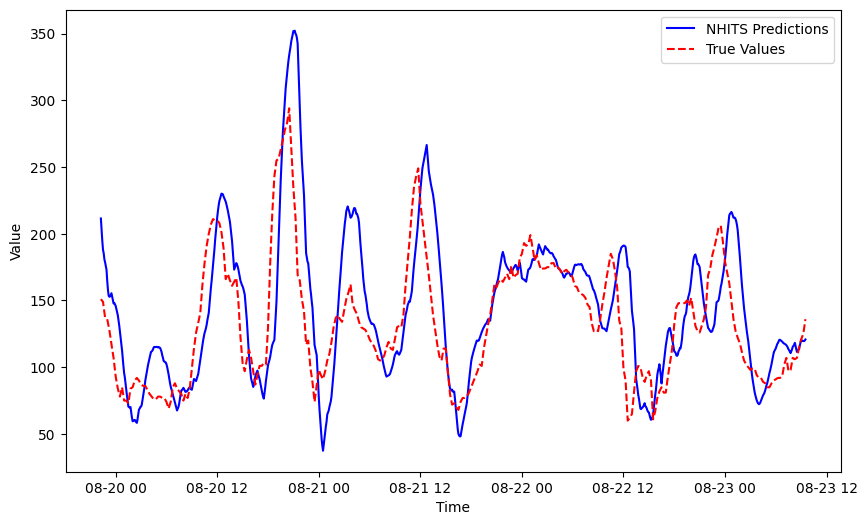

In [ ]:
import matplotlib.pyplot as plt

plot_data = cv_p27_filtered[:1000]

plt.figure(figsize=(10, 6))
plt.plot(plot_data['ds'], plot_data['AutoNHITS'], label='NHITS Predictions', color='blue')
plt.plot(plot_data['ds'], plot_data['y'], label='True Values', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### train univariate with validation (MAE loss)

In [19]:
test_p27_glucose.shape

(30129, 3)

In [ ]:
#from datasetsforecast.long_horizon import LongHorizon

Y_df = pd.concat([train_p27_glucose, test_p27_glucose])#train_multi_glucose
n_time = len(Y_df.ds.unique())
val_size = int(.2 * n_time)
test_size = int(.2 * n_time)

Y_df.groupby('unique_id').head(2)

unique_id                  ds      y
0       P27 2020-06-26 22:15:00  112.0
1       P27 2020-06-26 22:20:00  105.0

In [ ]:
n_time, val_size, test_size

(150645, 30129, 30129)

In [ ]:
horizon = 12 # 1h.

nhits_config = {
       "learning_rate": tune.choice([1e-3]),                                     # Initial Learning rate
       "max_steps": tune.choice([1000]),                                         # Number of SGD steps
       "input_size": tune.choice([5 * horizon]),                                 # input_size = multiplier * horizon
       "batch_size": tune.choice([7]),                                           # Number of series in windows
       "windows_batch_size": tune.choice([256]),                                 # Number of windows in batch
       "n_pool_kernel_size": tune.choice([[2, 2, 2], [16, 8, 1]]),               # MaxPool's Kernelsize
       "n_freq_downsample": tune.choice([[168, 24, 1], [24, 12, 1], [1, 1, 1]]), # Interpolation expressivity ratios
       "activation": tune.choice(['ReLU']),                                      # Type of non-linear activation
       "n_blocks":  tune.choice([[1, 1, 1]]),                                    # Blocks per each 3 stacks
       "mlp_units":  tune.choice([[[512, 512], [512, 512], [512, 512]]]),        # 2 512-Layers per block for each stack
       "interpolation_mode": tune.choice(['linear']),                            # Type of multi-step interpolation
       "val_check_steps": tune.choice([100]),                                    # Compute validation every 100 epochs
       "random_seed": tune.randint(1, 10),
    }

In [ ]:
models = [AutoNHITS(h=horizon,
                    config=nhits_config,
                    num_samples=5)]

In [ ]:
nf = NeuralForecast(
    models=models,
    freq='15min')

Y_hat_df = nf.cross_validation(df=Y_df, val_size=val_size,
                               test_size=test_size, n_windows=None)

In [ ]:
nf.models[0].results.get_best_result().config


{'learning_rate': 0.001,
 'max_steps': 1000,
 'input_size': 60,
 'batch_size': 7,
 'windows_batch_size': 256,
 'n_pool_kernel_size': [2, 2, 2],
 'n_freq_downsample': [24, 12, 1],
 'activation': 'ReLU',
 'n_blocks': [1, 1, 1],
 'mlp_units': [[512, 512], [512, 512], [512, 512]],
 'interpolation_mode': 'linear',
 'val_check_steps': 100,
 'random_seed': 7,
 'h': 12,
 'loss': MAE(),
 'valid_loss': MAE()}

#### model evaluation

In [ ]:
y_true = Y_hat_df.y.values
y_hat = Y_hat_df['AutoNHITS'].values

n_series = len(Y_df.unique_id.unique())

y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)

print('Parsed results')
print('2. y_true.shape (n_series, n_windows, n_time_out):\t', y_true.shape)
print('2. y_hat.shape  (n_series, n_windows, n_time_out):\t', y_hat.shape)

Parsed results
2. y_true.shape (n_series, n_windows, n_time_out):	 (1, 30118, 12)
2. y_hat.shape  (n_series, n_windows, n_time_out):	 (1, 30118, 12)


In [ ]:
from neuralforecast.losses.numpy import mae, mse, mape

print('MAE: ', mae(y_hat, y_true))
print('MSE: ', mse(y_hat, y_true))
print('MAPE: ', mape(y_hat, y_true))


MAE:  10.10662053705834
MSE:  258.53816328669353
MAPE:  0.08527424922379508


In [ ]:
y_hat[:, :, -1]

array([[151.0328 , 153.7192 , 140.34189, ..., 168.34749, 171.65106,
        174.16513]], dtype=float32)

In [ ]:
# Evaluation for 1h prediction

print('MAE: ', mae(y_hat[:, :, -1], y_true[:, :, -1]))
print('MSE: ', mse(y_hat[:, :, -1], y_true[:, :, -1]))
print('MAPE: ', mape(y_hat[:, :, -1], y_true[:, :, -1]))


MAE:  17.714697351875216
MSE:  614.5875309345079
MAPE:  0.14911319044882593


<ipython-input-74-f156f5dc0dc1>:1: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range(start='2020-01-01 00:00', periods=500, freq='5T')  # 300 points with 5-minute intervals


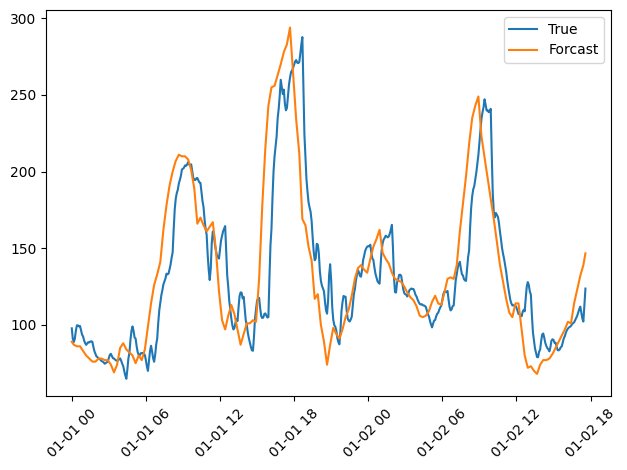

In [ ]:
time_index = pd.date_range(start='2020-01-01 00:00', periods=500, freq='5T')  # 300 points with 5-minute intervals

plt.plot(time_index,y_hat[0, 200:700, -1],label='True')
plt.plot(time_index,y_true[0, 200:700, -1],label='Forcast')
plt.legend()
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()